# EDA & Insights – Winter Mountain Tour Demand & Cancellations

## Objectives
- Explore seasonal booking patterns by region.
- Quantify the uplift from bank holiday weeks and peak winter.
- Understand how weather and calendar features relate to bookings.
- Explore cancellation patterns, especially under severe weather.
- Generate figures and narrative insights to support hypotheses H1–H3.

## Inputs
- `data/processed/weekly_bookings_regression.csv`
- `data/processed/bookings_for_classification.csv`

## Outputs
- EDA figures saved to `reports/figures/`
- Textual insights that will be re-used in the README and dashboard.


In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = Path("..").resolve()
DATA_PROCESSED = BASE_DIR / "data" / "processed"
FIG_DIR = BASE_DIR / "reports" / "figures"

FIG_DIR.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid")


In [5]:
weekly = pd.read_csv(
    DATA_PROCESSED / "weekly_bookings_regression.csv",
    parse_dates=["week_start"]
)

bookings_clf = pd.read_csv(
    DATA_PROCESSED / "bookings_for_classification.csv",
    parse_dates=["tour_date", "booking_date", "week_start"]
)

weekly.head(), bookings_clf.head()


(      region week_start  bookings_count  mean_temp_c  precip_mm  \
 0  highlands 2025-01-06              39     0.039111  22.199585   
 1  highlands 2025-01-13              29     3.477432  30.135563   
 2  highlands 2025-01-20              33     7.164116  45.228408   
 3  highlands 2025-01-27              21     7.475139  41.118787   
 4  highlands 2025-02-03              25     0.846858  48.099646   
 
    snowfall_flag  wind_speed_kph  visibility_km weather_severity_bin  year  \
 0              0        2.373245       7.130601                 mild  2025   
 1              0       49.353812       8.026752               severe  2025   
 2              0       38.264073       8.558483             moderate  2025   
 3              0       34.961207       8.732666             moderate  2025   
 4              0       52.343862       7.459206               severe  2025   
 
    week_number  month  is_bank_holiday_week  is_peak_winter  lag_1w_bookings  \
 0            2      1           

WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/weekly_bookings_by_region.png')

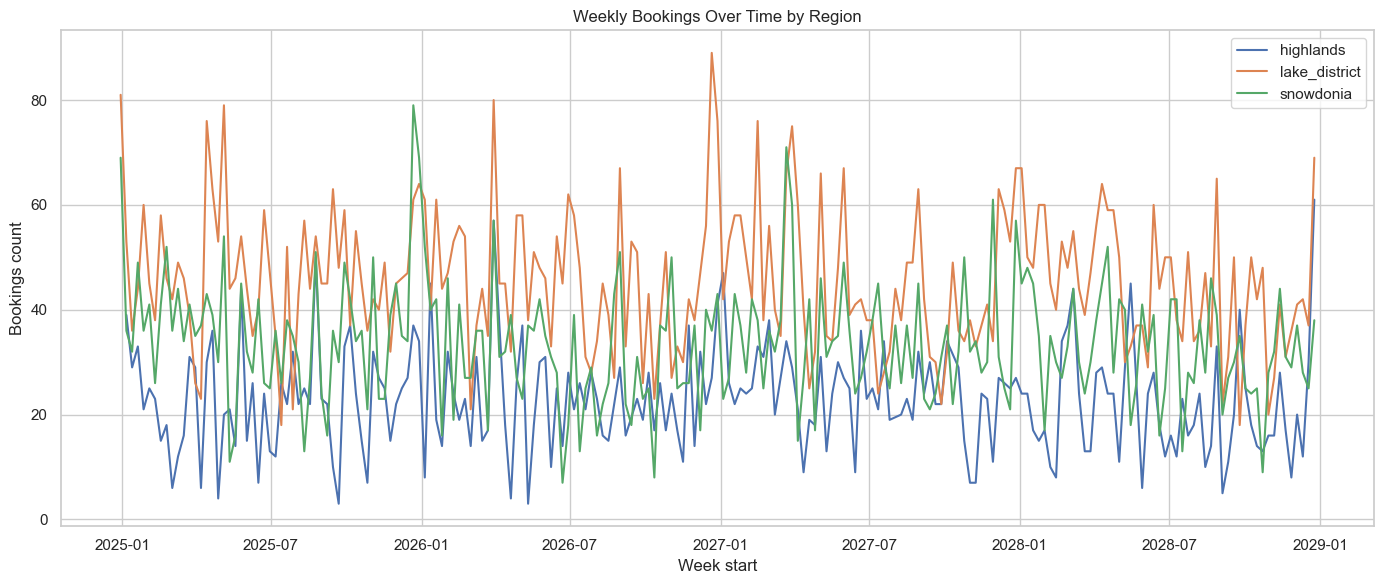

In [6]:
plt.figure(figsize=(14, 6))
for region, grp in weekly.groupby("region"):
    plt.plot(grp["week_start"], grp["bookings_count"], label=region)

plt.title("Weekly Bookings Over Time by Region")
plt.xlabel("Week start")
plt.ylabel("Bookings count")
plt.legend()
plt.tight_layout()

fig_path = FIG_DIR / "weekly_bookings_by_region.png"
plt.savefig(fig_path, dpi=120)
fig_path


### Insight 1 – Seasonality Patterns by Region (supports H1, H3)

The weekly bookings time series shows clear **seasonal peaks** during winter months
and known holiday periods. Regions such as the Lake District exhibit consistently
higher baseline demand compared to others, with visible surges during peak weeks.

This supports the idea that:
- Seasonality and holidays are key drivers of demand (H1).
- Recent history (lagged demand) is likely to be informative, as peaks and troughs
  tend to persist over short time windows (H3).


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/heatmap_week_region_bookings.png')

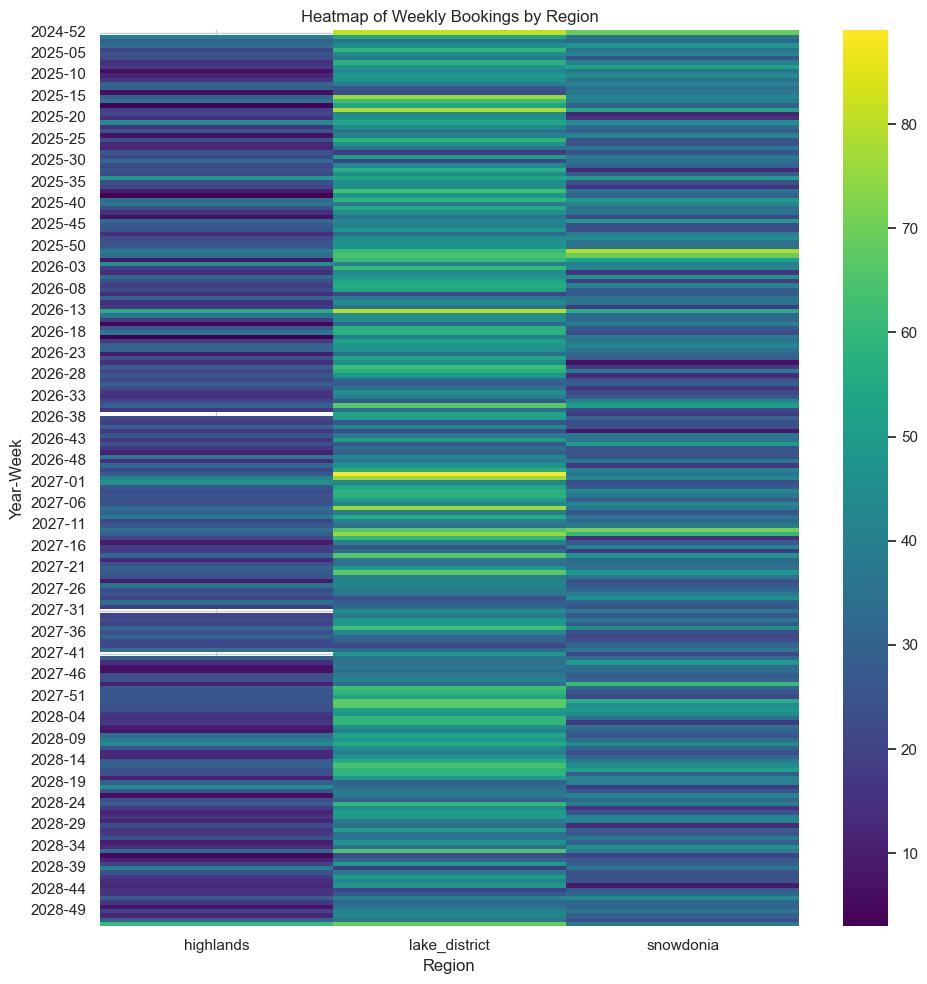

In [7]:
# Use year-week as a string label for plotting
weekly["year_week"] = weekly["week_start"].dt.strftime("%Y-%U")

pivot = weekly.pivot_table(
    index="year_week",
    columns="region",
    values="bookings_count",
    aggfunc="sum"
)

plt.figure(figsize=(10, 10))
sns.heatmap(pivot, cmap="viridis")
plt.title("Heatmap of Weekly Bookings by Region")
plt.xlabel("Region")
plt.ylabel("Year-Week")
plt.tight_layout()

fig_path = FIG_DIR / "heatmap_week_region_bookings.png"
plt.savefig(fig_path, dpi=120)
fig_path


### Insight 2 – Week × Region Heatmap

The heatmap highlights **clusters of high-demand weeks** across regions.
Peak-intensity bands align with winter and holiday periods, confirming that
these time windows consistently generate more bookings.

This reinforces:
- The importance of modelling **calendar features** (week number, month,
  peak winter, bank holiday flags).
- The need for the dashboard to show differences across regions so
  Operations can plan region-specific staffing.


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/holiday_uplift_bar.png')

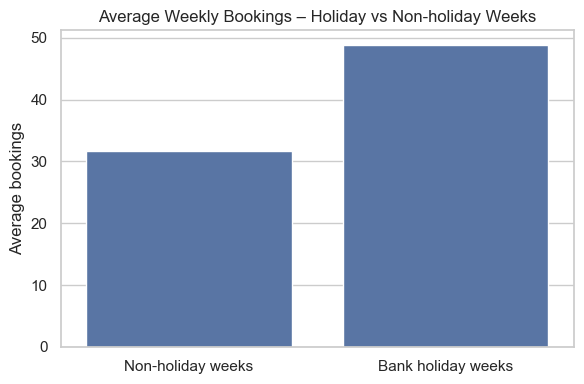

In [8]:
holiday_summary = (
    weekly.groupby("is_bank_holiday_week", as_index=False)["bookings_count"]
    .mean()
    .rename(columns={"bookings_count": "avg_bookings"})
)

holiday_summary["holiday_label"] = holiday_summary["is_bank_holiday_week"].map(
    {0: "Non-holiday weeks", 1: "Bank holiday weeks"}
)

holiday_summary

plt.figure(figsize=(6, 4))
sns.barplot(
    data=holiday_summary,
    x="holiday_label",
    y="avg_bookings"
)
plt.title("Average Weekly Bookings – Holiday vs Non-holiday Weeks")
plt.xlabel("")
plt.ylabel("Average bookings")
plt.tight_layout()

fig_path = FIG_DIR / "holiday_uplift_bar.png"
plt.savefig(fig_path, dpi=120)
fig_path



### Insight 3 – Holiday Uplift in Weekly Bookings (H1)

The bar chart shows that **bank holiday weeks have higher average bookings**
than non-holiday weeks. This supports **Hypothesis H1**: holidays create
a measurable uplift in demand across the regions.

Operationally, this means:
- Bank holiday weeks should be treated as **high-priority weeks** for staffing and capacity planning.
- The regression model should include bank holiday flags as key features to capture this uplift.


In [9]:
cancel_by_weather = (
    bookings_clf.groupby("weather_severity_bin", as_index=False)["was_cancelled"]
    .mean()
    .rename(columns={"was_cancelled": "cancellation_rate"})
)

cancel_by_weather


,weather_severity_bin,cancellation_rate
0,mild,0.109651
1,moderate,0.203110
2,severe,0.355335


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/cancellation_rate_by_weather.png')

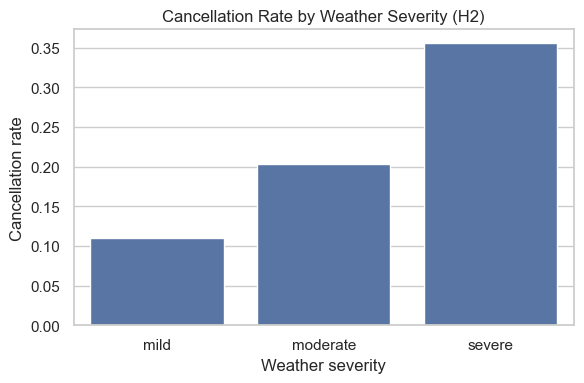

In [10]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=cancel_by_weather.sort_values("cancellation_rate"),
    x="weather_severity_bin",
    y="cancellation_rate"
)
plt.title("Cancellation Rate by Weather Severity (H2)")
plt.xlabel("Weather severity")
plt.ylabel("Cancellation rate")
plt.tight_layout()

fig_path = FIG_DIR / "cancellation_rate_by_weather.png"
plt.savefig(fig_path, dpi=120)
fig_path


### Insight 4 – Cancellations and Weather Severity (H2)

The plot shows that **cancellation rates increase with weather severity**:
bookings in "severe" weather weeks have a noticeably higher cancellation rate
than those in mild conditions.

This provides early support for **Hypothesis H2**:
> severe weather is associated with higher cancellations, independent of season.

From an operational standpoint:
- High-severity weather weeks are good candidates for **proactive reminders**
  or contingency plans (e.g. offering alternative dates).
- Weather severity should be included as a key feature in the classification model.


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/correlation_matrix_weekly.png')

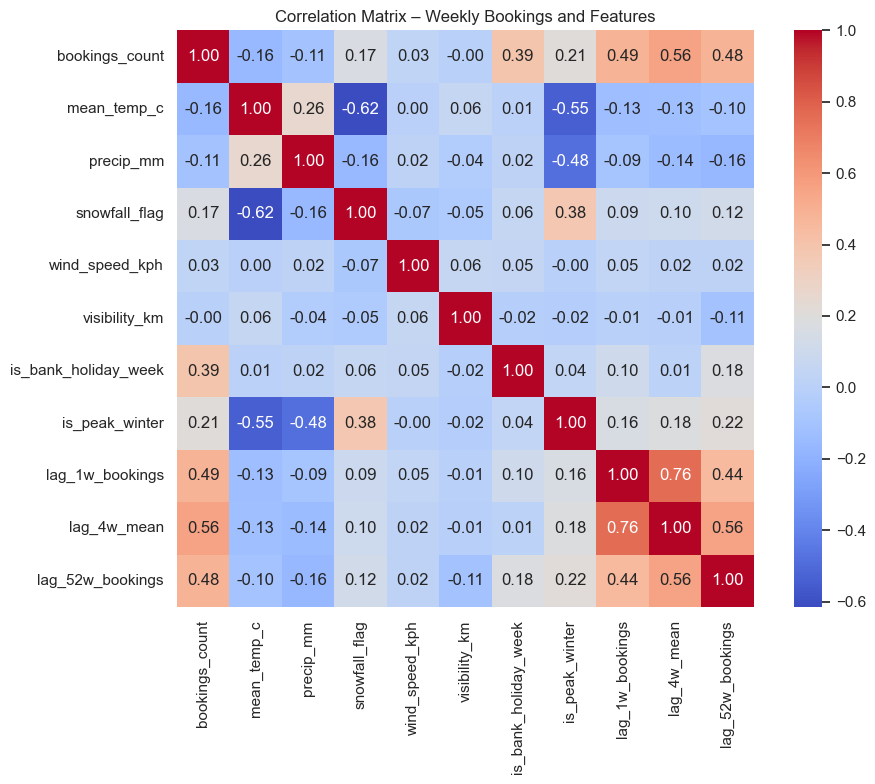

In [11]:
num_cols = [
    "bookings_count",
    "mean_temp_c",
    "precip_mm",
    "snowfall_flag",
    "wind_speed_kph",
    "visibility_km",
    "is_bank_holiday_week",
    "is_peak_winter",
    "lag_1w_bookings",
    "lag_4w_mean",
    "lag_52w_bookings",
]

corr = weekly[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix – Weekly Bookings and Features")
plt.tight_layout()

fig_path = FIG_DIR / "correlation_matrix_weekly.png"
plt.savefig(fig_path, dpi=120)
fig_path


### Insight 5 – Correlation Structure and Lag Features (H3)

The correlation matrix highlights that:
- Lag features such as `lag_1w_bookings` and `lag_4w_mean` have a **strong positive
  correlation** with current `bookings_count`.
- Calendar indicators like `is_bank_holiday_week` and `is_peak_winter` also show
  positive correlation with bookings, but typically weaker than recent demand.

This supports **Hypothesis H3**:
> lagged demand is one of the strongest single predictors of next week’s bookings.

It also justifies including both:
- **Lag features** (to capture temporal momentum).
- **Calendar features** (to capture structural uplift from holidays and peak winter).
